# Toxic Comment Analysis

The internet has given people the freedom of speech like no other. Yet, quoting the late Uncle Ben:
> with great internet connection, comes great responsibility

Indeed, it is tempting to just use word embedding combined with a sequence-based model such as LSTM , but I won't understand why does it work in this case. Does it really solve the biased prediction problem? Not to mention why auxiliary attributes improve the performance of the model and is widely used. For this reason, I reside to the "traditional" EDA method, hoping to get a better sense of the dataset before preprocessing or developing any models. There is no fancy stuff going on, but I believe we can still learn a thing or two using simple methods.

In this kernel, I explore some features of the toxic comments that is not commonly discussed in other EDA kernels. First, I look into annotators and their labels. Since every comments can have different number of annotators, is there any difference in the agreement level? Next, I revisited toxic subtypes and identity columns to see whether those attributes can help us identify toxic comments. I continue with lexical analysis, hoping to find any distinguishable characteristics between toxic and safe comments. Finally, I dig deeper into the unintended bias and see what kind of comments are misclassified using a simple keyword-based prediction.

Can we capture some toxic villains today?

<img src="https://media.giphy.com/media/3xz2BIIBBvBS8iDofm/giphy.gif" alt="internet-fight-spiderman" /> <br />
*(source: giphy)*

In [1]:
# basic imports
import string
import re
import gc
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm._tqdm_notebook import tqdm_notebook as tqdm; tqdm.pandas()

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import TruncatedSVD

# dataframe options to display the whole comments
pd.set_option('display.max_colwidth', -1)

# extra config to have better visualization
sns.set(
    style='whitegrid',
    palette='coolwarm',
    rc={'grid.color' : '.96'}
)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 30
plt.rcParams["figure.titleweight"] = 'bold'

In [2]:
# pandas dataframe background gradient to consider all rows and columns.
# By default, background gradient styling in pandas only consider by column.
# function taken from: https://stackoverflow.com/questions/38931566/pandas-style-background-gradient-both-rows-and-columns
def background_gradient(s, m, M, cmap='PuBu', low=0, high=1):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [3]:
# data loading
# use only training set
train = pd.read_csv('../input/train.csv')
train.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [4]:
toxic_subtypes = [
    'severe_toxicity',
    'obscene',
    'threat',
    'insult',
    'identity_attack',
    'sexual_explicit'
]

identity_attrs = [
    'asian', 'atheist', 'bisexual',
    'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
    'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
    'jewish', 'latino', 'male', 'muslim', 'other_disability',
    'other_gender', 'other_race_or_ethnicity', 'other_religion',
    'other_sexual_orientation', 'physical_disability',
    'psychiatric_or_mental_illness', 'transgender', 'white',
]

identity_attrs_group = {
    'gender': ['female', 'male', 'transgender', 'other_gender'],
    'race': ['asian', 'black', 'jewish', 'latino', 'white', 'other_race_or_ethnicity'],
    'religion': ['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion'],
    'sexual_orientation': ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation'],
    'disability': ['intellectual_or_learning_disability', 'physical_disability', 'psychiatric_or_mental_illness', 'other_disability']
}

# 1. Understanding Toxic Annotations

The first part examines the dependent variable and potential auxiliary attributes.

## 1.1 Toxic comments distribution

In [5]:
# create a 0 or 1 column and see the proportion
train['is_toxic'] = train['target'] >= 0.5
toxic_count = train['is_toxic'].value_counts()
toxic_prop = toxic_count / len(train['is_toxic'])
print("There are {:,} ({:.2f}%) toxic comments out of {:,} comments in the dataset".format(
    toxic_count[True],
    toxic_count[True] * 100 / len(train['is_toxic']),
    len(train['is_toxic'])
))

There are 144,334 (8.00%) toxic comments out of 1,804,874 comments in the dataset


Toxic comments account only 8% of the training data, meaning we are dealing with **imbalanced** dataset. How about the actual agreed toxicity level distribution of the annotators?

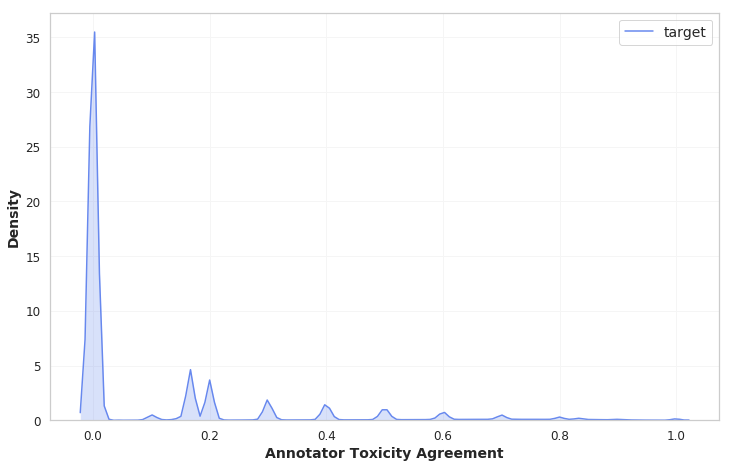

In [6]:
fig, ax = plt.subplots(figsize=(12, 7.5))
_ = sns.kdeplot(train['target'], shade=True, ax=ax)
_ = ax.set(xlabel='Annotator Toxicity Agreement', ylabel='Density')

As expected, most of the comments were deemed non-toxic by all of the annotators. However, when it comes to toxic comments, it is hardly unanimous. The number of comments with target score equal to 1.0 is really small. Another boggling thing is the number of annotators for each comment can be different. Is it correct to assume that more annotators means more believable? Let's check if the toxicity of a comment is related to the number of annotators.

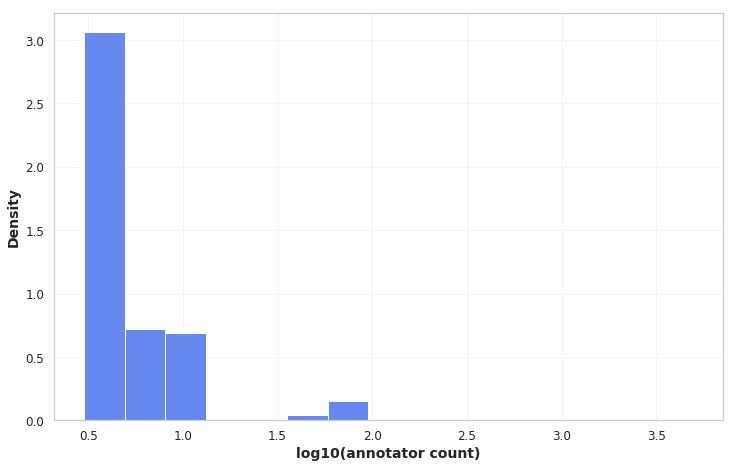

In [7]:
train['log_toxicity_annotator_count'] = np.log10(train['toxicity_annotator_count'])
fig, ax = plt.subplots(figsize=(12, 7.5))
_ = train['log_toxicity_annotator_count'].hist(bins=15, density=True, ax=ax)
_ = ax.set(xlabel='log10(annotator count)', ylabel='Density')

There seems to be two clusters in terms of the number of annotators: below 10^1.5 and above 10^1.5. Is there any difference in the toxicity agreement of those two clusters?

There are 1,729,080 comments with number of annotators below 10^1.5 and 75,794 above 10^1.5.


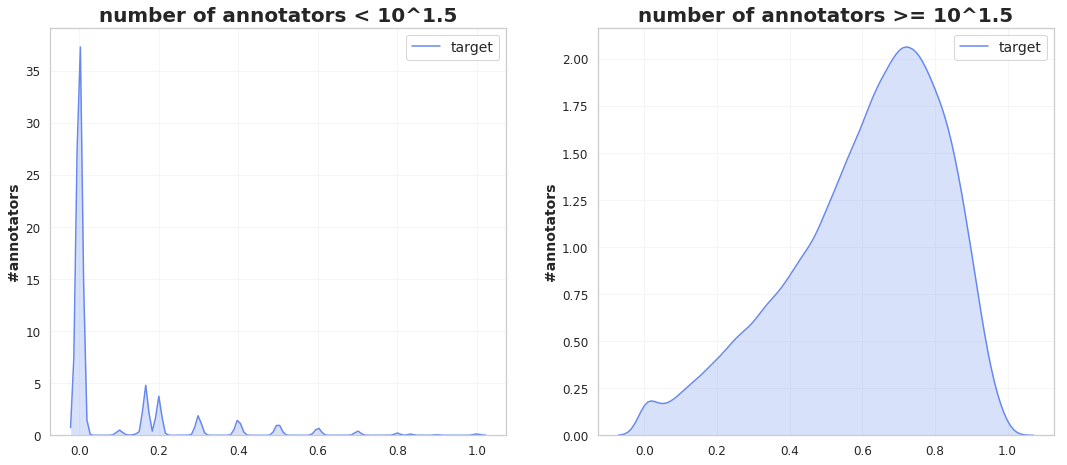

In [8]:
train['many_annotators'] = train['log_toxicity_annotator_count'] >= 1.5

print("There are {:,} comments with number of annotators below 10^1.5 and {:,} above 10^1.5.".format(
    len(train[train['log_toxicity_annotator_count'] < 1.5]),
    len(train[train['log_toxicity_annotator_count'] >= 1.5])
))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7.5))

_ = sns.kdeplot(
    train[~train['many_annotators']]['target'], 
    shade=True,
    ax=ax1
)
_ = ax1.set_title('number of annotators < 10^1.5')
_ = ax1.set_ylabel('density')
_ = ax1.set_ylabel('#annotators')

_ = sns.kdeplot(
    train[train['many_annotators']]['target'], 
    shade=True,
    ax=ax2
)
_ = ax2.set_title('number of annotators >= 10^1.5')
_ = ax2.set_ylabel('density')
_ = ax2.set_ylabel('#annotators')


The two graphs above reveal some degree of correlation between the number of annotators with the toxic comments. When the number of annotators is more than 10^1.5, the target score peaked towards 0.7. Looking at the data description page, this phenomenon is intentional due to imposed strategy, although we are not presented with the details:
> Some comments were seen by many more than 10 annotators (up to thousands), due to sampling and strategies used to enforce rater accuracy.

By analysing the number of annotators, we can exploit the information to give more attention to comments with more annotators when we train our model. This initial analysis suggests the possibility of various weight for each comment depending on the number of annotators. 

The following sub-sections about subtypes and identities are common in other EDA kernels as well, but it is good to re-visit them. I see subtypes are being used as auxiliary attributes during training but not identities, what could be the reason?

## 1.2 Toxic Subtypes Distribution

Let's find out which sub-types are the most common.

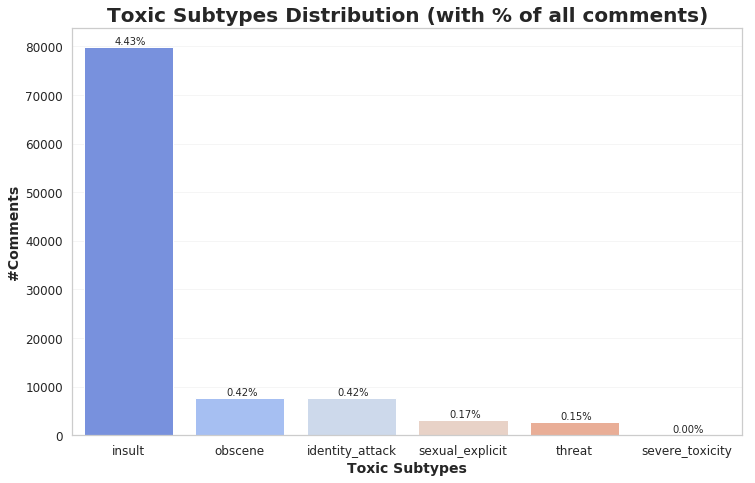

In [9]:
subtypes_count = (train[toxic_subtypes] > 0.5).sum(axis=0).sort_values(ascending=False)
subtypes_prop = np.round(subtypes_count * 100 / len(train), 2)
fig, ax = plt.subplots(figsize=(12, 7.5))
_ = sns.barplot(x=subtypes_count.index, y=subtypes_count.values, ax=ax)
_ = ax.set_title('Toxic Subtypes Distribution (with % of all comments)')
_ = ax.set_xlabel('Toxic Subtypes')
_ = ax.set_ylabel('#Comments')

for p, label in zip(ax.patches, subtypes_prop.values):
    ax.annotate("{:.2f}%".format(label), (p.get_x()+0.275, p.get_height()+500))

As shown, it is clear that *insult* is the dominant type of toxic comments. The number of *insult* comments is 10x the number of the closest next two categories: *obscene* and *identity_attack*. I am not quite sure what each type means, it is good to see an example for each:

In [10]:
subtype_examples = []
for subtype_col in toxic_subtypes:
    comment = train[[subtype_col, 'toxicity_annotator_count', 'comment_text']].sort_values(
        by=[subtype_col, 'toxicity_annotator_count'], ascending=False).iloc[0]
    subtype_examples.append({
        'subtype' : subtype_col,
        'comment' : comment['comment_text'],
        'subtype_toxicity_level' : comment[subtype_col],
        'num_annotators' : comment['toxicity_annotator_count']
    })
subtype_examples_df = pd.DataFrame(subtype_examples).set_index('subtype')
subtype_examples_df

,comment,num_annotators,subtype_toxicity_level
subtype,,,
severe_toxicity,"Awesome! Lets cut the head off hate! Lets stab it and burn its house down! lets march together and beat hate with rocks and clubs and run out out of town! Hooray for us for showing hate we will not tolerate it and will kill or beat down any that oppose or stance against hate. \n\nYeah, that sounds like the good guys. Why is it so hard for people to admit that using violence to achieve a goal is not acceptable in a civil society?",4,1.0
obscene,"Quarantine should end with a bullet between the eyes. What crap to be attacked by a loose dog. I hate it when a loose dog comes running up, and the owner says he is friendly. Bear spray to the face",10,1.0
threat,"WHY do they allow them to plea down? I was abused, he should hang by the neck until dead.",10,1.0
insult,Typical dumb Anchorage thugs. I cannot believe how many of these idiots we have in this town.,72,1.0
identity_attack,"You realize you're equating ""white nationalists"" with Muslim terrorists, murderers, and hate groups.\n\nI agree.",11,1.0
sexual_explicit,"Yes, the VAGINA negates everything, unless it's being used for making more rethuglican rugrats, pleasure, or, on rare occasion, shooting Ping Pong balls.\n\nAt least that's how the GOP view women.",10,1.0


Looking at the examples, it seems this subtypes are not supposed to be mutually exclusive. The example of *sexual_explicit* also has some degree of *insult* ("...rethuglican rugrats, pleasure, or, on rare occasion, shooting Ping Pong balls..."). Similarly with the example of *obscene* which include some sort of threat ("Quarantine should end with a bullet between the eyes ... Bear spray to the face."). How related each types and also with the target?

In [11]:
corr = train[toxic_subtypes + ['target']].corr()
corr.style.apply(background_gradient, m=corr.min().min(), M=corr.max().max()).set_precision(2)

,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,target
severe_toxicity,1,0.34,0.28,0.32,0.26,0.2,0.39
obscene,0.34,1,0.091,0.43,0.12,0.33,0.49
threat,0.28,0.091,1,0.11,0.15,0.088,0.29
insult,0.32,0.43,0.11,1,0.31,0.15,0.93
identity_attack,0.26,0.12,0.15,0.31,1,0.12,0.45
sexual_explicit,0.2,0.33,0.088,0.15,0.12,1,0.25
target,0.39,0.49,0.29,0.93,0.45,0.25,1


To my surprise, *insult* and *target* correlation score is really high: 0.93! Although *obscene* and *identity_attack* have 0.49 and 0.45, respectively, but 0.93 is just another level. Maybe we should focus on predicting *insult* as the definition of *toxic*?

## 1.3 Identity Distribution

In [12]:
identity_df = train[identity_attrs].dropna(axis=0, how='all')
print("There are {:,} ({:.2f}% of all training set) identity-labelled comments, out of which {:,} ({:.2f}%) are not identity offensive.".format(
    len(identity_df),
    len(identity_df) * 100 / len(train),
    len(identity_df[np.sum(identity_df, axis=1) == 0]),
    len(identity_df[np.sum(identity_df, axis=1) == 0]) * 100 / len(identity_df)
))

There are 405,130 (22.45% of all training set) identity-labelled comments, out of which 178,896 (44.16%) are not identity offensive.


The first reason why identity columns are not as helpful as subtypes is the data availability. Only 22.45% of the training set are labelled and half of them are not considered toxic. Let's explore the distribution of comments that have been labelled with identities:

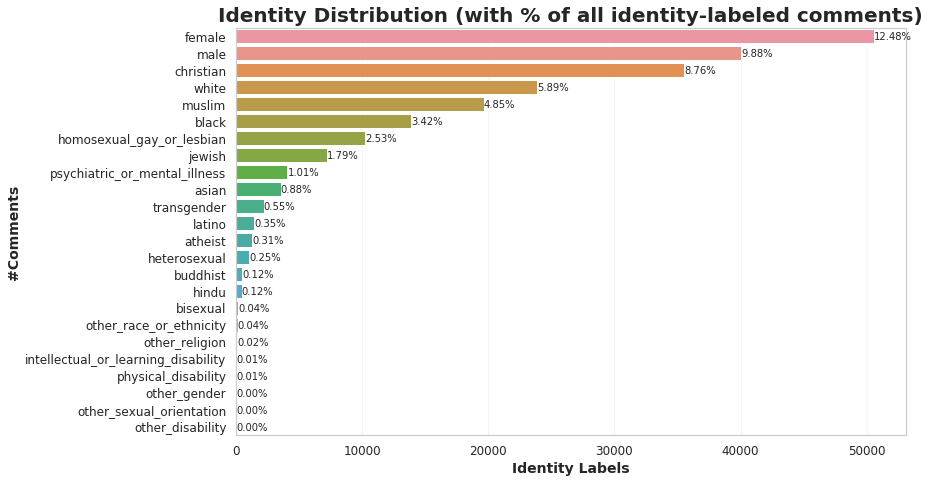

In [13]:
identity_count = (identity_df > 0.5).sum(axis=0).sort_values(ascending=False)
identity_prop = np.round(identity_count * 100 / len(identity_df), 2)
fig, ax = plt.subplots(figsize=(12, 7.5))
_ = sns.barplot(x=identity_count.values, y=identity_count.index, ax=ax)
_ = ax.set_title('Identity Distribution (with % of all identity-labeled comments)')
_ = ax.set_xlabel('Identity Labels')
_ = ax.set_ylabel('#Comments')

for p, label in zip(ax.patches, identity_prop.values):
    ax.annotate("{:.2f}%".format(label), (p.get_width(), p.get_y()+0.6))

And if we group the identity columns:

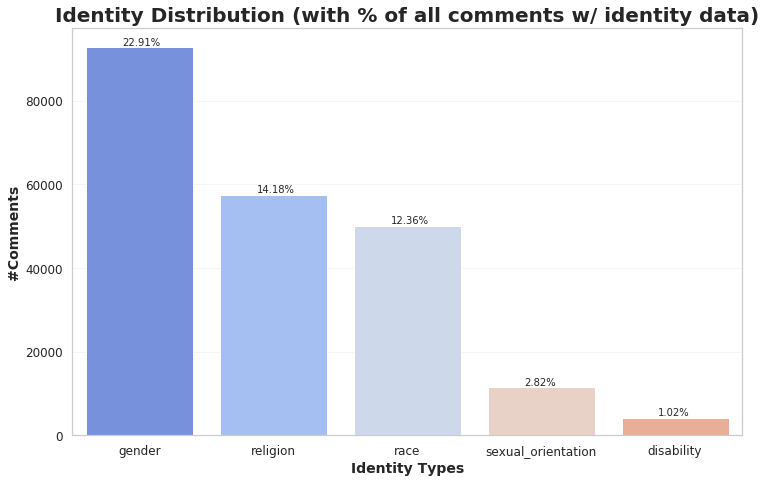

In [14]:
identity_group_count = pd.Series(
    dict(
        (g, np.sum(identity_count[identity_count.index.isin(identity_attrs_group[g])])) 
        for g in identity_attrs_group)
).sort_values(ascending=False)
identity_group_prop = np.round(identity_group_count * 100 / len(identity_df), 2)
fig, ax = plt.subplots(figsize=(12, 7.5))
_ = sns.barplot(x=identity_group_count.index, y=identity_group_count.values, ax=ax)
_ = ax.set_title('Identity Distribution (with % of all comments w/ identity data)')
_ = ax.set_xlabel('Identity Types')
_ = ax.set_ylabel('#Comments')

for p, label in zip(ax.patches, identity_group_prop.values):
    ax.annotate("{:.2f}%".format(label), (p.get_x()+0.275, p.get_height()+500))

The most popular identity is regarding *gender* followed by *religion* and *race*, still not so dominating as *insult* subtype. How about the correlation with the *target*?

In [15]:
identity_group_df = pd.DataFrame()
for g in identity_attrs_group:
    identity_group_df[g] = np.max(identity_df[identity_attrs_group[g]], axis=1)
identity_group_w_target_df = identity_group_df.join(train['target'], how='left')
corr = identity_group_w_target_df.corr()
corr.style.apply(background_gradient, m=corr.min().min(), M=corr.max().max()).set_precision(2)

,gender,race,religion,sexual_orientation,disability,target
gender,1,0.019,-0.043,0.068,-0.0094,0.097
race,0.019,1,0.0074,0.0047,-0.027,0.22
religion,-0.043,0.0074,1,0.066,-0.037,0.071
sexual_orientation,0.068,0.0047,0.066,1,-0.0027,0.13
disability,-0.0094,-0.027,-0.037,-0.0027,1,0.061
target,0.097,0.22,0.071,0.13,0.061,1


With such low correlation, identity columns are not a promising auxiliary attributes. Except *race* and *sexual_orientation*, the correlation to target is almost 0. Even *race*, which has the highest correlation, only score 0.22.

## 1.4 Toxic Subtypes and Identity Correlation

As we are interested about *insult* subtypes, is there any correlation between the identity columns to the subtypes?

In [16]:
identity_group_w_subtypes_df = identity_group_df.join(train[toxic_subtypes], how='left')
corr = identity_group_w_subtypes_df.corr()
corr = corr.loc[toxic_subtypes, list(identity_attrs_group.keys())]
corr.style.apply(background_gradient, m=corr.min().min(), M=corr.max().max()).set_precision(2)

,gender,race,religion,sexual_orientation,disability
severe_toxicity,0.046,0.11,0.039,0.065,0.02
obscene,0.044,0.023,-0.021,0.027,0.0074
threat,0.033,0.054,0.026,0.016,0.012
insult,0.067,0.13,0.0086,0.063,0.078
identity_attack,0.085,0.43,0.24,0.25,0.0033
sexual_explicit,0.16,-0.019,-0.0016,0.11,-0.0036


Of course *identity_attack* is somewhat correlated with the identity columns, but we do not find any meaningful correlation between any of the identity groups with either *target* or *insult*. Thus, identity columns are not really helpful when we want to predict *target*.

# 2. Comments Analysis

## 2.1 Lexical analysis

The purpose of the lexical analysis is to see comments characteristic before moving on to understanding them semantically. Can we get some clue about the toxicity of a comment based on the total number of characters in the comment or the average word length? Another aspect that we can investigate is the part-of-speech. The hypothesis is that toxic comments consist of adjectives. Let's consult the data to find the answer:

In [17]:
def plot_cdf(ax, df, col, xlabel):
    _ = ax.hist(df[(df['target'] >= 0.5) & (df[col] < df[col].quantile(.99))][col], 200, 
                               density=True, histtype='step', color='red',
                               cumulative=True, label='toxic')
    _ = ax.hist(df[(df['target'] < 0.5) & (df[col] < df[col].quantile(.99))][col], 200,
                               density=True, histtype='step', color='blue',
                               cumulative=True, label='non-toxic')
    _ = ax.legend(loc='upper left')
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel('Proportion')
    
    return ax

In [18]:
train['char_length'] = train['comment_text'].progress_apply(lambda c: len(c))
train['tokenized_comment'] = train['comment_text'].progress_apply(
    lambda c: [t.lower() for t in re.split("[\s\-—]+", c.translate(str.maketrans('', '', string.punctuation))) if len(t) > 0]
)
train['num_tokens'] = train['tokenized_comment'].progress_apply(lambda c: len(c))
train['average_token_length'] = train['tokenized_comment'].progress_apply(lambda c: np.mean([len(t) for t in c]) if len(c) > 0 else 0)
train['comment_sentences'] = train['comment_text'].progress_apply(lambda c: sent_tokenize(c))
train['number_of_sentences'] = train['comment_sentences'].progress_apply(lambda s: len(s))
train['capital_letters_prop'] = train['comment_text'].progress_apply(lambda c: sum(1 for i in c if i.isupper()) / len(c))
train['non_alphanumeric_prop'] = train['comment_text'].progress_apply(lambda c: sum(1 for t in c if not t.isalnum()) / len(c))

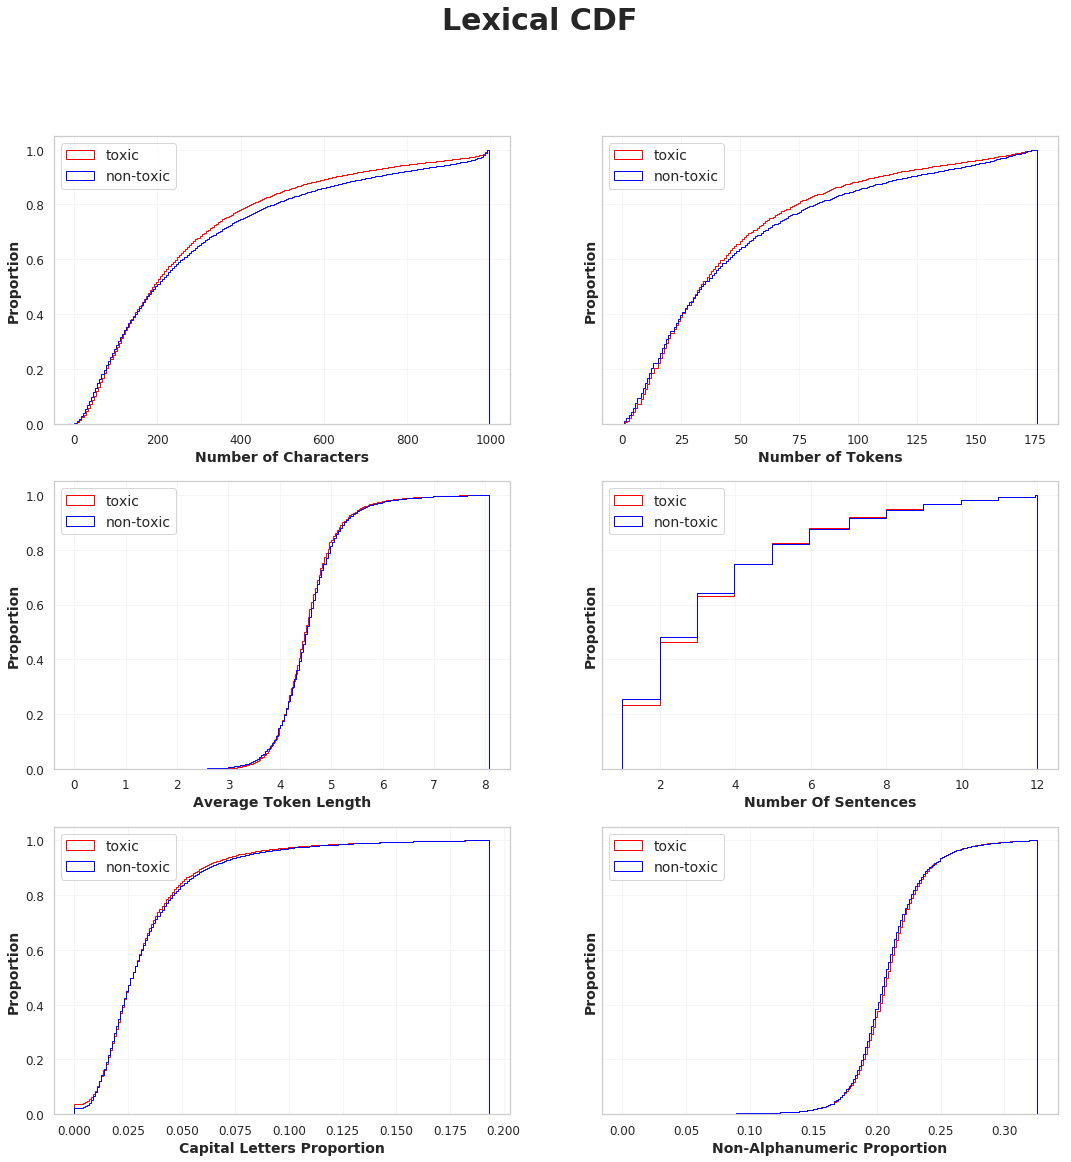

In [19]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharey=True, figsize=(18, 18))
plt.suptitle('Lexical CDF')

_ = plot_cdf(axs[0,0], train, 'char_length', 'Number of Characters')
_ = plot_cdf(axs[0,1], train, 'num_tokens', 'Number of Tokens')
_ = plot_cdf(axs[1,0], train, 'average_token_length', 'Average Token Length')
_ = plot_cdf(axs[1,1], train, 'number_of_sentences', 'Number Of Sentences')
_ = plot_cdf(axs[2,0], train, 'capital_letters_prop', 'Capital Letters Proportion')
_ = plot_cdf(axs[2,1], train, 'non_alphanumeric_prop', 'Non-Alphanumeric Proportion')

Well, there is no significant difference between toxic and safe comments in any of the plots. We can observe, barely, that toxic comments tend to be longer with more number of tokens (or words). However, there is an usual spike for non-toxic comments with more than 950 characters. Seems some safe comments are (extremely) elaborative, but in general the longer means more likely to be toxic, also as shown by the number of sentences plot.

Another hypothesis is that using a lot of capital letters and punctuation marks (e.g. a burst of exclamation or question marks) might signal toxic comments. However, there is no evidence of such thing in terms of capital letters and non-alphanumeric proportion. If that's the case, then using lower-case and removing alpha-numeric should be fine. It is worth to take another look at this with POS analysis.

## 2.2 POS analysis

It is remarkable how a human can call another human with obscure words in an online forum. Based on personal observation, I suspect toxic comments contain more adjective than safe comments. Fortunately, NLTK has a default POS tagger for english. It might not work that well for online forum contents due to colloquial languages, but it can help us to some extent in verifying our hypothesis.

For the POS analysis, I am going to use downsampling for the non-toxic class mainly due to memory limitation. Downsampling is done randomly.

In [20]:
n = len(train[train['target'] >= 0.5])
train_sample = pd.concat([train[train['target'] >= 0.5].sample(n=n, random_state=1336), train[train['target'] < 0.5].sample(n=2*n, random_state=1337)])
del identity_df
del train
_ = gc.collect()

n_train_sample = len(train_sample)
print("The number of samples: {:,}".format(n_train_sample))

The number of samples: 433,002


In [21]:
train_sample_pos = train_sample.join(
    train_sample['tokenized_comment'].progress_apply(
        lambda c: pd.Series(Counter('POS_' + p[:2] + '_prop' for w,p in pos_tag(c))) / len(c)
    )
)

In [22]:
pos_columns = ['POS_JJ_prop', 'POS_NN_prop', 'POS_IN_prop',
       'POS_PR_prop', 'POS_VB_prop', 'POS_CC_prop', 'POS_MD_prop',
       'POS_RB_prop', 'POS_TO_prop', 'POS_DT_prop', 'POS_WD_prop',
       'POS_EX_prop', 'POS_WP_prop', 'POS_CD_prop', 'POS_WR_prop',
       'POS_PD_prop', 'POS_RP_prop', 'POS_UH_prop', 'POS_FW_prop',
       'POS_\'\'_prop', 'POS_PO_prop', 'POS_$_prop']
train_sample_pos[pos_columns + ['target']].corr()['target'].sort_values(ascending=False)[1:]

POS_PR_prop    0.055128
POS_PD_prop    0.053550
POS_JJ_prop    0.051554
POS_RP_prop    0.046285
POS_CC_prop    0.021666
POS_FW_prop    0.020492
POS_WP_prop    0.019195
POS_WD_prop    0.005486
POS_VB_prop    0.000945
POS_EX_prop   -0.000353
POS_DT_prop   -0.002836
POS_''_prop   -0.017624
POS_NN_prop   -0.021231
POS_TO_prop   -0.025364
POS_MD_prop   -0.026682
POS_WR_prop   -0.028601
POS_RB_prop   -0.033749
POS_$_prop    -0.068161
POS_IN_prop   -0.083119
POS_UH_prop   -0.083723
POS_CD_prop   -0.089425
POS_PO_prop   -0.111784
Name: target, dtype: float64

Although small, these POS tags have positive correlation with the target value:
1. PR: pronouns (her, hers, himself)
2. PD: predeterminers (all, half, both)
3. JJ: adjectives
4. RP: particles (about)

They are not as significant as expected, but we can get a sense of the construction of a toxic comment. Let's see the CFD:

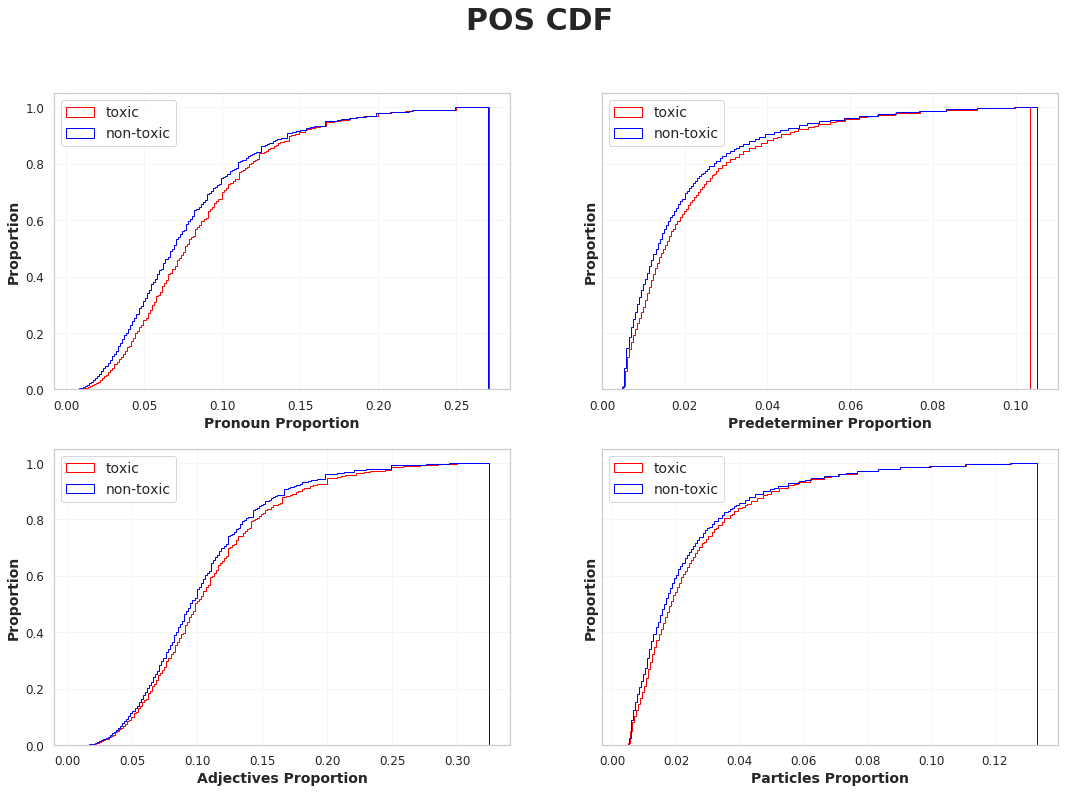

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(18, 12))
plt.suptitle('POS CDF')

_ = plot_cdf(axs[0,0], train_sample_pos, 'POS_PR_prop', 'Pronoun Proportion')
_ = plot_cdf(axs[0,1], train_sample_pos, 'POS_PD_prop', 'Predeterminer Proportion')
_ = plot_cdf(axs[1,0], train_sample_pos, 'POS_JJ_prop', 'Adjectives Proportion')
_ = plot_cdf(axs[1,1], train_sample_pos, 'POS_RP_prop', 'Particles Proportion')

On the other side, these POS tags are a sign of a safe comments:
1. PO: possessive ending (person's)
2. CD: digits
3. UH: interjection (uh, yeah, ah)
4. IN: preposition/conjunction (on, in, but)

This means, we should put more attention when we are handling those words during preprocessing. It is better to keep numbers, but maybe we can change them as a same token ("DIGIT"). Handling possesive ending seems relevant. Interjection, which seems to be meaningless, is worth a second look. Lastly, we need to be cautious about stopwords removal, does it remove prepositions? Before concluding, see in details for those 4 POS tags:

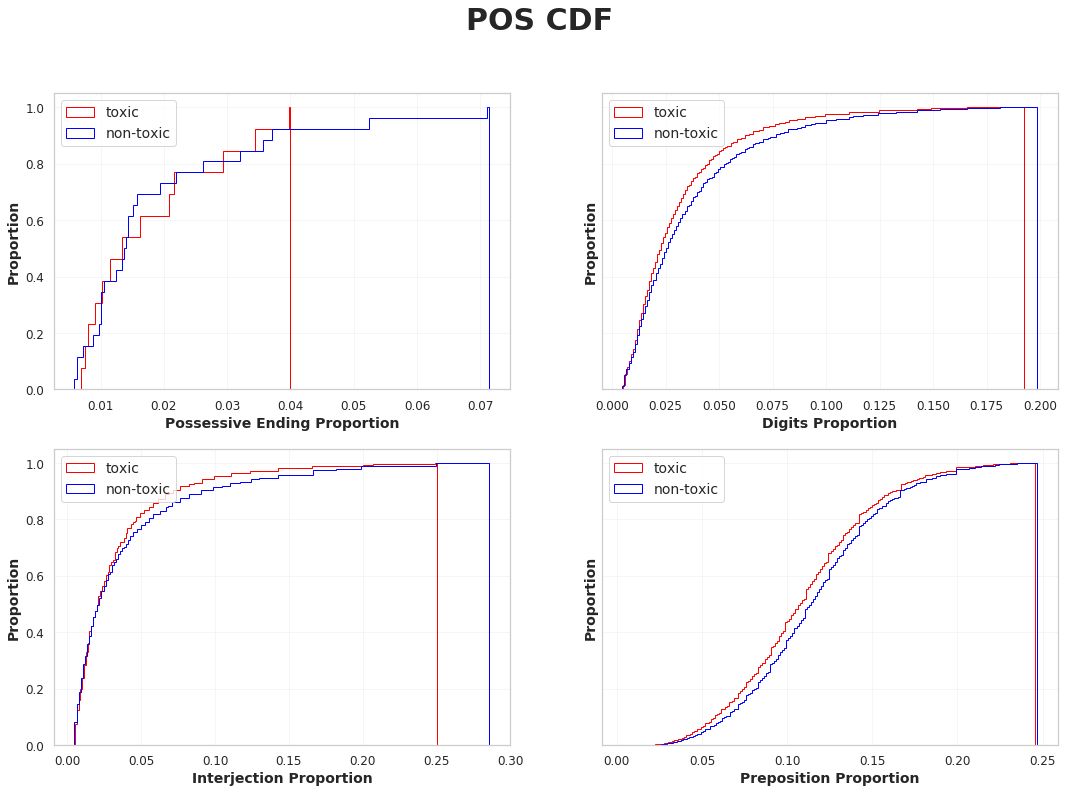

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(18, 12))
plt.suptitle('POS CDF')

_ = plot_cdf(axs[0,0], train_sample_pos, 'POS_PO_prop', 'Possessive Ending Proportion')
_ = plot_cdf(axs[0,1], train_sample_pos, 'POS_CD_prop', 'Digits Proportion')
_ = plot_cdf(axs[1,0], train_sample_pos, 'POS_UH_prop', 'Interjection Proportion')
_ = plot_cdf(axs[1,1], train_sample_pos, 'POS_IN_prop', 'Preposition Proportion')

For possessive endings, there are not many occurrences of the POS (looking at the number of "steps" in the chart) and it might be overfitting to those specific comments. This may also be the case for interjection. In terms of digits and preposition, however, higher proportion tend to be a safe comment.

Note that since the POS tags correlation with the target value is really small either for positive and negative, it might not be that useful for predicting target value. Nevertheless, it offers a hint if using stopwords provide better results than removing them.

# 3. Vocabulary

After we analyse the lexical characteristic of the comments, we are ready to touch the surface of semantic analysis. I am using a simple method called Term Frequency - Inverse Document Frequency (TF-IDF) to capture the importance of a word in a comment. TF-IDF has many flaws, of course, but it is a quick way of feature engineering without building any models. Moreover, it is definitely better than just a frequency-based bag-of-words. Subsequently, I use (yet another) simple naive bayes model to find which terms are important predictors.

## 3.1 TF-IDF

One of the weakness of TF-IDF is the inability to capture the similarity of the same word on different forms. As an illustration, "available" and "availability" are just as different as "apple" and "duck". The only way to capture the relationship between words are their co-occurrences in sentences. To handle this, I am using a stemmer. Stemming is not a fool-proof technique because we will lose some degree of information by doing so. However, as I want to analyze which word is the most relevant for a toxic/safe comments, not building the most accurate model, stemming should come in handy for now. Also, stopwords are not removed as preposition and interjection are positively correlated with safe comments.

In [25]:
stemmer = SnowballStemmer("english")
train_sample['stemmed_comment'] = train_sample['tokenized_comment'].progress_map(lambda c: ' '.join([stemmer.stem(t) for t in c]))
comment_df = train_sample[['comment_text', 'stemmed_comment', 'toxicity_annotator_count', 'target']].sample(frac=1, random_state=1338)
del train_sample_pos
del train_sample
_ = gc.collect()

In [26]:
# constructing TF-IDF term-weighting vocabulary
# Only words that occur in at least 50 comments are included
vectorizer = TfidfVectorizer(min_df=50, max_df=.15, ngram_range=(1, 2))
train_n = int(0.1 * n_train_sample)
X_train = vectorizer.fit_transform(comment_df[:train_n]['stemmed_comment'])
X_test = vectorizer.transform(comment_df[train_n:]['stemmed_comment'])
y_train = comment_df[:train_n]['target'] >= 0.5
y_test = comment_df[train_n:]['target'] >= 0.5
print("Number of vocabulary: {:,}".format(len(vectorizer.get_feature_names())))

Number of vocabulary: 6,857


We can see which terms have the highest weight by using the average of TF-IDF value:

In [27]:
avg_tfidf = np.asarray(X_train.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': vectorizer.get_feature_names(), 'avg_tfidf': avg_tfidf})
weights_df.sort_values(by='avg_tfidf', ascending=False).head(25)

,term,avg_tfidf
2373,he,0.016199
6147,trump,0.013824
6580,will,0.013758
6387,we,0.013245
3240,like,0.012794
3648,no,0.012777
2475,his,0.012621
5674,their,0.012594
4885,so,0.012414
2078,from,0.012059


It is interesting to see that among the highest average tf-idf are mostly what are usually considered as stopwords (he, so, an). We can see that those terms have the highest weights, but are they a good predictor for toxic comments? Naive Bayes to the rescue.

## 3.2 Naive Bayes

We want to model a comment being toxic given the term weights of words in the comment. We calculate the probability by looking at the probability of a toxic comments among all comments, probability of each word in a toxic comment, and the probability of the word itself among all corpora.

Because we have 6.857 words in our vocabulary, each comment is represented as a vector with length 6.857, and most of the elements are zeros. In the end, our goal is to see which words are predictors of toxic/safe comments.

In [28]:
def informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t{:8.4f} * {:15}\t\t{:8.4f} * {:15}".format(coef_1, fn_1, coef_2, fn_2))

Because we are dealing with imbalanced dataset, I am using sample weighting. As the number of safe comments are twice the number of toxic comments in the sample, the weight of the toxic comments are twice the weight of a safe comment during training. In other words, we force the model to perform well on predicting a toxic comment correctly.

In [29]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train, sample_weight=list(y_train * 0.5 + 0.5))
y_pred_nb = nb_model.predict(X_test)
y_prob_nb = nb_model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob_nb)
fpr, tpr, threshold = roc_curve(y_test, y_prob_nb)
print(confusion_matrix(y_test, y_pred_nb))

[[192361  67462]
 [ 26207 103672]]


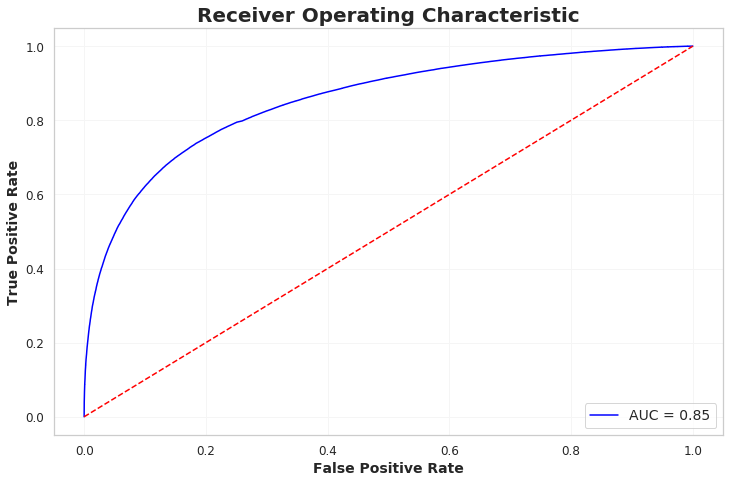

In [30]:
fig, ax = plt.subplots(figsize=(12, 7.5))
_ = ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
_ = ax.legend(loc = 'lower right')
_ = ax.plot([0, 1], [0, 1],'r--')
_ = ax.set_title('Receiver Operating Characteristic')
_ = ax.set_ylabel('True Positive Rate')
_ = ax.set_xlabel('False Positive Rate')

In [31]:
informative_features(vectorizer, nb_model)

	-11.0309 * incent         		 -5.6573 * trump          
	-10.8728 * updat          		 -5.6644 * he             
	-10.7768 * suffici        		 -5.8585 * stupid         
	-10.7668 * the latter     		 -5.8966 * his            
	-10.7648 * the fund       		 -5.9671 * like           
	-10.7634 * risk of        		 -5.9859 * peopl          
	-10.7380 * entiti         		 -6.0399 * just           
	-10.7277 * rental         		 -6.0536 * who            
	-10.7122 * compani that   		 -6.0788 * no             
	-10.6975 * innov          		 -6.0881 * their          
	-10.6967 * tax is         		 -6.0970 * so             
	-10.6810 * year it        		 -6.1160 * will           
	-10.6797 * will still     		 -6.1346 * we             
	-10.6714 * exempt         		 -6.1460 * an             
	-10.6567 * in oregon      		 -6.1982 * about          
	-10.6563 * reduc the      		 -6.2093 * by             
	-10.6411 * of oil         		 -6.2136 * idiot          
	-10.6208 * the purpos     		 -6.2142 * get     

The left and right column shows keywords that contribute the most to predict as safe and toxic, respectively. Indeed some stopwords are a good predictor (his, will, an, by), so definitely we have to tailor which stopwords to be removed. Stopwords like "the" and "of" can still be removed, because they appeared in the list but does not contribute to the meaning itself ("latter" should suffice as a standalone token as it has the same meaning as "the latter").

In [32]:
pred_df = pd.DataFrame()
pred_df['true'] = y_test.astype(int)
pred_df['prob'] = y_prob_nb
fp_indices = pred_df[(pred_df['true'] == 0) & (pred_df['prob'] >= 0.5)]['prob'].sort_values(ascending=False).index
tp_indices = pred_df[(pred_df['true'] == 0) & (pred_df['prob'] < 0.5)]['prob'].index
comment_df.loc[fp_indices[:25]][['comment_text', 'target', 'toxicity_annotator_count']].sort_values(['target'])

,comment_text,target,toxicity_annotator_count
1342734,"China has not exactly been any American president's best friend when it comes to North Korea. Obama actually accomplished a tad bit more than Bush. It was Clinton that lost the best opportunity to actually be effective. \n\nI have been watching the despicable events unfolding in Charlottesville, and once again the man you voted for refuses to identify white supremacy as a problem. I really and truly pray that every white pro life Christian that voted for the supposedly 'pro life' president meditates on the license they have given for others to hate and hate and hate and be proud of their 'patriotic' hate. Please don't ever again tell anyone here their 'hatred of Mr Trump color everything', when Trump supporters are marching to paint this country exclusively white. The silence from the white Christian Trump supporter is as equally despicable as the virulent white men screaming 'blood and soil'.",0.000000,4
1766043,You're a stone-cold MO-Ron.,0.000000,4
1658663,There is no white supremacist in the White House.,0.000000,4
1729610,Not clowns?,0.000000,4
582489,"the sooner the left wing nut jobs like you realize trump is going no where since the GOP are clearly with him the better you can start looking inward at the left's issues that are the ones needing to be ""Impeached"" from society. the usa goes on regardless of the ignorance and hate left wingers live in",0.000000,4
908836,"There was a small cohort of anarchist who split off, but far and away the marchers were orderly. You lie by omission, and for a partisan purpose. Here's the straight story about Trump rallies: https://www.nytimes.com/video/us/politics/100000004533191/unfiltered-voices-from-donald-trumps-crowds.html\nYou probably won't look at it this time, either, but these videos show how truly awful Trump's base is. Nonstop cursing, assaults, incredible stupidity and ignorance. You asked for it, you got it, you deserve it, Donald J Trump. The ignorance and brutish behavior of Trump's base is more than disgusting, it's unbelievable that such hate and filth can emanate from so many of our citizens. Go ahead Motley, watch the video. That's you screaming lunacy.",0.166667,6
1366618,"Here's a letter for patriotic Americans to send to Trump:\n\nDear Mr. President,\nI’m sickened by your behavior this past week. Your refusal to seriously denounce White Supremacists and Nazis is an embarrassment to this country.\nThis is UNACCEPTABLE and UNAMERICAN.\nThat’s why I’m sending this letter, calling for your immediate resignation.\n\nIf you don't resign, every bit of effort and every extra dollar I have will go towards destroying the Republican party and voting Democrats into office.\nI reject your xenophobic, racist and sexist agenda. And I REFUSE to let your hateful and bigoted comments go unanswered. I am committed to fighting for what’s right, and that means making sure you and your Republican backers are voted out of office.\n\nYour shameful moral character and self-serving leadership makes you absolutely unfit to be President of the United States.\n\nYour presidency is an absolute disaster. And your power is coming to an end.\n\nSincerely,\n\nRTD",0.200000,10
1361316,"Stop deflecting to the past. You and everybody else with eyes know who now coddles and makes concessions to the KKK, neo-nazis and white supremacists. Not every republican is a white supremacist, but every white supremacist is a republican!",0.200000,10
1289839,... WHAT A PHONEY LIAR FAKEY SPOILED BRAT 'christian' ...,0.254545,55
1053981,Crooked Jerk!,0.366667,60


Looking at some examples of false positive, we can observe some comments that have arguable target value. I cannot understand why "Effin moron" and "Crooked Jerk!" are not considered toxic comments. Even a comment like "You're a stone-cold MO-Ron." has a target value of 0. Those might suggest that we have to take extra measure in cleaning the dataset.

We can also see comments that have target value really close to the toxic threshold (0.5) have be rounded as "safe" comments questionably. "Overpaid, childish, morons" is definitely an insult, but still half of 71 annotators considered it to be safe. As the data is imbalanced, it is considerable to neglect comments with doubtful target value during training, maybe it is good to ignore comments that has value between 0.4 to 0.6.

Finally, we can see the "biased" classification of a comment if we are using keyword-based modeling. As this competition suggested, using keywords only is not sufficient to predict toxic comments. Many safe comments are labelled as toxic due to the keywords, while it really depends on the context. "There is no white supremacist in the White House." is an excellent example of a safe comment (target value = 0) that might be mis-classified due to 2 occurrences of "white" word. And we know that this is a difficult task when the model is only presented with a two-word comment "Not clowns?" and asked to determine whether it is toxic or not without any additional context when the word "clown" is used in other comments with a mixed sentiment. Hard, even for sequence-based models. Or is it?

# 4. Lesson Learned

These are the key insights I have gathered from this EDA that should help during preprocessing and when building the actual model:
1. We are dealing with imbalanced dataset (92% vs 8%). I do not see any public kernels talk about how to handle this issue (or if we **should** handle this issue).
2. There is a correlation between the number of annotators and the toxicity value, which might suggest to take number of annotators into account during training. Not as feature, of course, because the test set does not provide the number of annotators. It can be useful as a sample-weighting method.
3. The most popular toxic subtypes is insult, it dominates other subtypes. Even more intriguing, it has a (really) high correlation with target value, which bear a thought if the toxic definition in this dataset is actually "insulting".
4. Identity attributes are not helpful to predict target value due to the low label availability and absence of correlation.
5. There is a negligible difference in comment length, capital letters proportion, and alpha-numeric occurrence between toxic and safe comments. One can consider to do lowercase transformation and remove punctuations.
6. Some measurement into preprocessing: Don't remove digits (rather, replace to a "DIGIT" token, for example). It is an indication of a safe comment. Also, not all stopwords should be removed.
7. Some comments have a questionable target value, which means cleaning the (noisy) dataset is important before training the model. How to detect them? This is a subject for another kernel.
8. Comments with target value in the edge of the threshold is not reliable, consider ignoring comments with target value too close to 0.5. Or better yet, train a separate model to identify this (Ensemble?).

**FIN**: If you find anything wrong with my approach or something can be improved, kindly write in the comment below. All comments are welcome, but no toxic comments please ;)